In [42]:
import pandas as pd
import math
import numpy as np
from scipy.stats import norm 
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline


data = ("Feb_12_20_01.csv") #copy the address of the data into the bracket
df = pd.read_csv(data)
df.columns = ['XValue', 'Time', 'Laser_Power', 'Shutter', 'Ch_A', 'Ch_B', 'DE_exp', 'angle'] #comment out if i want to test book.csv
#df.columns = ["angle"]#, "p1", "p2"] #Uncomment this if i want to test book.csv
#df.head()



df = df.iloc[1:,] #comment out if i want to test book.csv
#df['angle_ext'] = 18 - df.angle
df.drop(df.columns[[0,2,3,4,5]], axis = 1, inplace = True) #comment out if i want to test book.csv

n = len(df.angle) #number of angles considered
Bragg_angle = np.deg2rad(18) #Bragg angle for red beam, it is 12 for blue beam
Bragg_angle = np.arcsin((1/1.5)*(np.sin(Bragg_angle)))
df.angle = np.deg2rad(df.angle) #convert angles to radians to make them suitable for trigonometry functions
df.angle = np.arcsin((1/1.5)*(np.sin(df.angle))) #Snell's law for the external angle
for i in range(n):
    #D_theta = (df.angle - Bragg_angle) #get the deviation from bragg angle
    D_theta = df.angle
df['Delta_theta'] = D_theta

'''Definition of variables
n_one is the index perturbation
L is the thickness of the recording layer
Lambda is the wavelength of the light in the vacuum
theta is the angle of reference beam outside the media (measured from normal)
K is the grating number (2*pi/period)
Period is the grating period
n_nut is the bulk index of the material
phi is grating slant angle inside the material measured from normal
Beta is 2piEpsilon_nut^0.5/lambda
Epsilon_nut is the bulk dielectric constant
Delta_lambda is the deviation from the Bragg condition for wavelength
Delta_theta is the deviation from the Bragg condition for angle'''


def onbragg(Lambda,Period,n_nut,phi,Delta_Lambda,Delta_n,L):
    K = (2*math.pi)/Period
    Beta = (2*math.pi*(n_nut))/Lambda
    nu = ((math.pi*Delta_n*L)/(Lambda)*((((np.cos(Bragg_angle)**2))-((K*np.cos(phi)*np.cos(Bragg_angle))/Beta))**0.5))
    DE_Kb = (np.sin(nu)**2)
    print ("The Modulation Parameter on bragg is: ", nu)
    print("Diffraction Efficiency at Bragg Condition is: ", DE_Kb)
    return DE_Kb
    
    
onbragg(633e-9, 1e-6, 1.5, 90, 0, 3.35e-3, 23e-6)


def kogelnik(Lambda,Period,n_nut,phi,Delta_Lambda,Delta_n,L):
    K = (2*math.pi)/Period
    Beta = (2*math.pi*(n_nut))/Lambda
    for i in range(n):
        nu = ((math.pi*Delta_n*L)/(Lambda)*((((np.cos(Bragg_angle)**2))-((K*np.cos(phi)*np.cos(Bragg_angle))/Beta))**0.5))
        xi = (((df.Delta_theta*K*np.sin(phi-Bragg_angle)-((Delta_Lambda*K**2)/(4*np.pi*n_nut)))*L)/2*((np.cos(df.angle))-(K*np.cos(phi))/Beta))
        df["xi"] = xi
        DE_K = (np.sin(((nu**2)+(df.xi**2))**0.5)**2)/(1+(df.xi**2)/(nu**2)) 
    return DE_K

'''Modifications
I changed theta from Bragg_angle to df.angle and left theta_nut as Bragg_angle
'''


DE_K = kogelnik(633e-9, 1e-6, 1.5, 90, 0, 3.25e-3, 24e-6)
df.Delta_theta = np.rad2deg(df.Delta_theta) #Convert Δθ from radians to degree
df.angle = np.rad2deg(df.angle)
#df.angle_ext = np.rad2deg(df.angle_ext)
df["DE_Kogelnik"] = DE_K
df.DE_exp = df.DE_exp - 0.01 #remove stray light
df.head() #View the top five rows
#display(df) #view all

The Modulation Parameter on bragg is:  0.4087559545490652
Diffraction Efficiency at Bragg Condition is:  0.15798087448970546


,Time,DE_exp,angle,Delta_theta,xi,DE_Kogelnik
1,46.599665,0.000416,-9.640209,-9.640209,-14.415652,0.000758
2,46.899682,0.000502,-9.574747,-9.574747,-14.320086,0.000805
3,46.899682,0.000502,-9.548558,-9.548558,-14.281839,0.000820
4,46.999688,0.000570,-9.522366,-9.522366,-14.243581,0.000833
5,47.099693,0.000591,-9.496171,-9.496171,-14.205312,0.000843


FloatSlider(value=1.0, description='Δn', max=5.0, min=1.0)

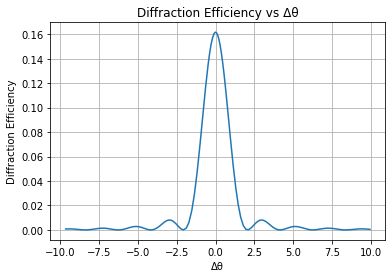

In [43]:
Slider = widgets.FloatSlider(min = 1, max = 5, value=1, description = "Δn" )
display(Slider)
Delta_n = Slider

#def updateplot(Delta_n):
#    DE_K = kogelnik(633e-9, 1e-6, 1.5, 0, 0, Delta_n, 20e-6)
#    return DE_K

df["DE_Kogelnik"] = DE_K
plt.plot(df.angle, df.DE_Kogelnik)
plt.title("Diffraction Efficiency vs Δθ")
plt.xlabel("Δθ")
plt.ylabel("Diffraction Efficiency")
#plt.ylim([0.992,1.001])
#plt.xlim([-30,15])
plt.grid()
plt.show()

#updateplot(Delta_n)

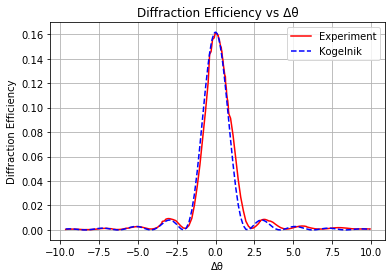

<Figure size 432x288 with 0 Axes>

In [44]:
#Plot the experiment data and fit Kogelnik
plt.plot(df.angle, df.DE_exp, color='red', linewidth=1.5, label ="Experiment")
plt.plot(df.angle, df.DE_Kogelnik, "--", color='blue', linewidth=1.5, label = "Kogelnik")
plt.title("Diffraction Efficiency vs Δθ")
plt.xlabel("Δθ")
plt.ylabel("Diffraction Efficiency")
plt.legend()
plt.grid()
plt.show()
 
plt.tight_layout()